# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

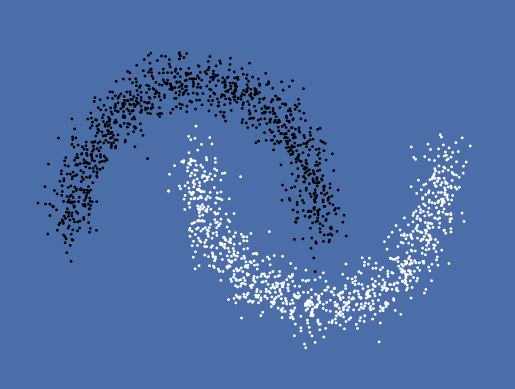

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()


In [4]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [5]:
import copy
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE

#         temp = np.array(x, dtype=float)
#         self.relu_forward_value = np.array(np.maximum(temp, 0.))
#         return self.relu_forward_value
    
        x_arr = np.array(x)
        self.relu_forward_value = (x_arr > 0).astype('float')
        return self.relu_forward_value * x_arr #assigning less than 0 to 0 and keeping others
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        
#         self.relu_backward_value = copy.deepcopy(self.relu_forward_value)
#         self.relu_backward_value[self.relu_backward_value >= 0] = 1 # or maybe '>' instead of '>='
#         self.relu_backward_value[self.relu_backward_value < 0]  = 0
        
        self.relu_backward_value = self.relu_forward_value * grad_output
        return self.relu_backward_value
#         return self.relu_backward_value
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        # YOUR CODE HERE
        self.sigmoid_foward_value = np.exp(-x)
        out = 1. / (1 + self.sigmoid_foward_value)
        return out
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        # YOUR CODE HERE
        self.sigmoid_backward_value = (grad_output * self.sigmoid_foward_value) / (self.sigmoid_foward_value + 1) ** 2
        return self.sigmoid_backward_value
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        # YOUR CODE HERE
        pass

Probably a good time to test your functions...

In [6]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

array([ 0. , -0. ,  0.5, -0. ,  0.8,  1. ])

In [7]:
test_relu.backward(np.ones(1))

array([0., 0., 1., 0., 1., 1.])

In [8]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [9]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [10]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(1,n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        self.x_backward = x.copy()
#         return x @ self.W + self.b # The @ operator can be used as a shorthand for np.matmul on ndarrays. which is used for matrix product of 2 arrays
        out = np.matmul(x, self.W) + self.b
        return out
        
    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        # YOUR CODE HERE
        
#         self.grad_W = (grad_output.T @ self.x_backward).T
        self.grad_W = (np.matmul(grad_output.T, self.x_backward)).T
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        # YOUR CODE HERE
        
        self.grad_b = grad_output.copy()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        
#         return grad_output @ self.W.T
        return np.matmul(grad_output, self.W.T)
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        # YOUR CODE HERE
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b
        pass

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [11]:
class Sequential(object):
    def __init__(self, network_layers):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        # YOUR CODE HERE
        self.network_layers = network_layers
        
    def forward(self, x):
        # YOUR CODE HERE
        for network_layer in self.network_layers : #forwarding layeres sequentionally
            x = network_layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        self.loss = - (label * np.log(out) + (1-label) * np.log(1-out))
        if label == 0:
            self.loss_grad =  (1-label) / (1-out + 1e-10)
        else:
            self.loss_grad = - label / (out + 1e-10)
        
        return self.loss
        
        
    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        current_grad = self.loss_grad
        for network_layer in reversed(self.network_layers):
            current_grad = network_layer.backward(current_grad)
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        # YOUR CODE HERE
         for network_layer in self.network_layers:
            network_layer.step(learning_rate)

In [12]:
# define your network with your Sequential Class
# YOUR CODE HERE

network = Sequential([
    MyLinear(2, 100),
    MyReLU(),
    MyLinear(100, 1),
    MySigmoid()
])


In [13]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        # YOUR CODE HERE
        rand_id = np.random.randint(1, len(X))
        
        # select the corresponding example and label
        # YOUR CODE HERE
        example = X[rand_id:rand_id+1]
        label = Y[rand_id]
        
        # do a forward pass on the example
        # YOUR CODE HERE
        net_forward_out = network.forward(example)

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        loss = network.compute_loss(net_forward_out, label)
        losses.append(loss.squeeze())

        
        # backward pass
        # YOUR CODE HERE
        network.backward()
        
        # gradient step
        # YOUR CODE HERE
        network.step(learning_rate)

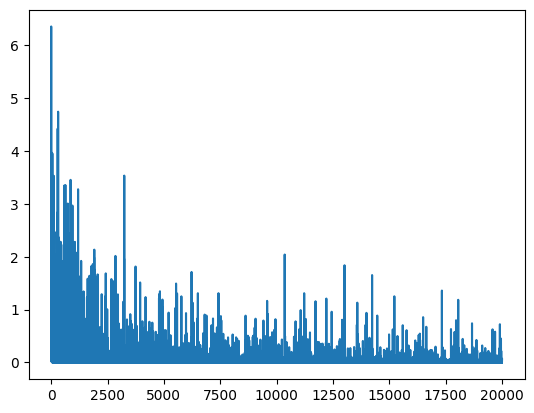

In [14]:
%matplotlib inline
plt.plot(losses)
plt.show()

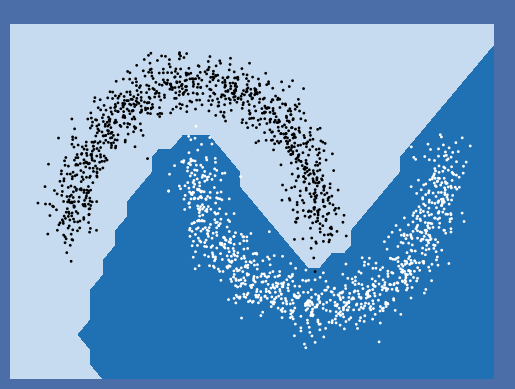

In [15]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

### q1
### TF-IDF   
Term Frequency – Inverse Document Frequency (TF-IDF) is a popular statistical technique utilized in natural language processing and information retrieval to assess a term’s significance in a document in comparison to a group of documents.    

Term Frequency: TF of a term or word is the number of times the term appears in a document compared to the total number of words in the document.
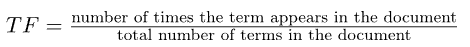

Inverse Document Frequency: IDF of a term reflects the proportion of documents in the corpus that contain the term. Words unique to a small percentage of documents receive higher importance values than words common across all documents.
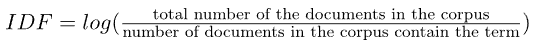

The TF-IDF of a term is calculated by multiplying TF and IDF scores.
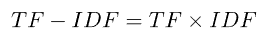

The importance of a term is high when it occurs a lot in a given document and rarely in others. In short, commonality within a document measured by TF is balanced by rarity between documents measured by IDF. The resulting TF-IDF score reflects the importance of a term for a document.

### q2

Stemming      => finding the root of a word.    
Lemmatization => findong common lemma.    

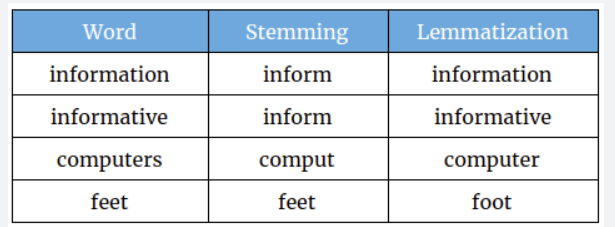

Stemming is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. For instance, stemming the word 'Caring' would return 'Car'.    
Lemmatization has higher accuracy than stemming. Lemmatization is preferred for context analysis, whereas stemming is recommended when the context is not important.     
Lemmatization is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.     
In this assignment we choose lemmatization to implement.    

### Implementing lemmatization as tokenizer

In [79]:
from nltk import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

ignored_tokens = ["<", "br", '"//"', ">", "\n", "\r", "<br />"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(ignored_tokens)
# print((my_stop_words))

def lemma_tokenizer(text) :
    wnl=WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(text) if (not t in stopwords.words() and not t in ignored_tokens)]



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### TfidVectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

IMDB = pd.read_csv('imdb_dataset.csv')
label_encoder = preprocessing.LabelEncoder()
IMDB['sentiment'] = label_encoder.fit_transform(IMDB['sentiment'])

# IMDB_tf = TfidfVectorizer(max_features = 5000).fit(IMDB['review'])
# x = IMDB_tf.fit_transform(IMDB['review'])
# x.shape 

In [19]:
print(IMDB['sentiment'].unique())

[1 0]


### Testing lemma_tokenizer

In [86]:
test_text = IMDB['review'][2]
tokenized = lemma_tokenizer(test_text)
print(test_text)
print('\n---------------------------------\n')
print(tokenized)
print(len(tokenized))

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.

---------------------------------

['I', 'wonderful', 'spend', 'time', '

In [180]:
from sklearn.model_selection import train_test_split
X = IMDB['review']
y = IMDB['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)


In [181]:
stop_words = set(stopwords.words('english'))

# X_tr_tf = TfidfVectorizer(max_features = 3000, tokenizer=lemma_tokenizer).fit(X_train) # taking too much time !!!
X_tr_tf = TfidfVectorizer(max_features = 3000, stop_words='english').fit(X_train)
X_train_tf = X_tr_tf.fit_transform(X_train)
X_train_tf.shape 

(37500, 3000)

In [182]:
X_ts_tf = TfidfVectorizer(max_features = 3000, stop_words='english').fit(X_test)
X_test_tf = X_ts_tf.fit_transform(X_test)
X_test_tf.shape 

(12500, 3000)

### q3

In [183]:
idx_pos=0
idx_neg=0
for i, sentim in y_train.items() :
    if(sentim) :
        idx_pos=i
        break
for i, sentim in y_train.items() :
    if(sentim==0) :
        idx_neg=i
        break
        
print('positive review with index: '+ str(idx_pos))
print(X_train[idx_pos])
print('\n')
print('negative review with index: '+ str(idx_neg))
print(X_train[idx_neg])

positive review with index: 40502
The show itself basically reflects the typical nature of the average youth; partying and picking up chicks is the common weekend goal at the clubs. People frown upon the show due to its "perverted" idea of picking up girls using technique and strategic characterization, but truth be told, practically every young guy is out doing it at the club. Overall, the show really appeals to the younger population, as we like to see the outcome of a "player's" performance at the club, as the show offers a comical approach made possible by the judging panel. <br /><br />10/10; a cool, fun and thrilling series that allows the audience to really interact. Good Job Boys.


negative review with index: 11681
Oh just what I needed,another movie about 19th century England. Which is pretty much like regular England,only nobody's vandalising football stadiums.In this picturesque setting of lords,dames and other randomly chosen titles,Charlotte Gainsbourg walks around aimles

### q4 

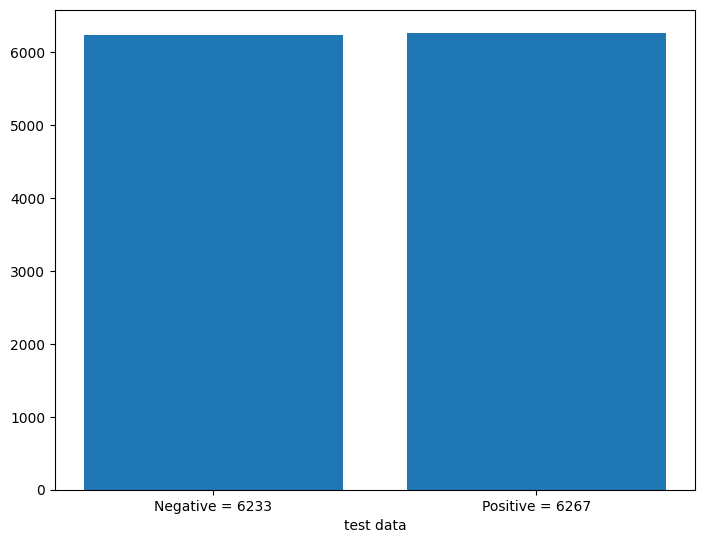

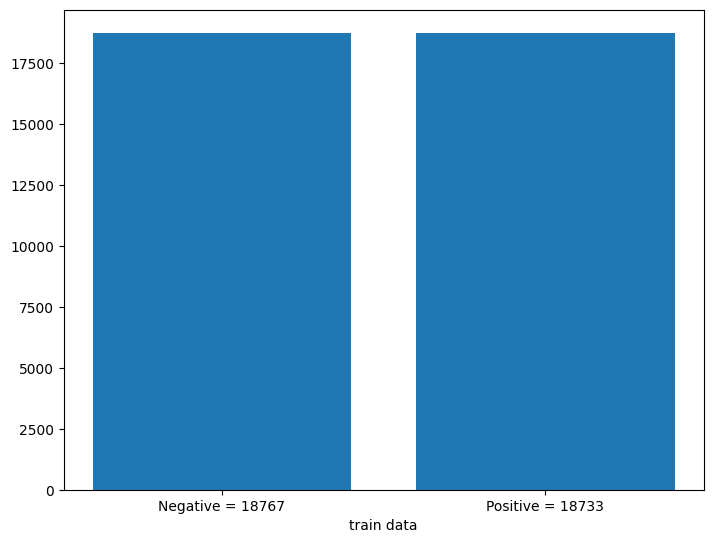

In [184]:
import matplotlib.pyplot as plt
sentiment_classes_test = [0 for x in range(2)]
sentiment_classes_train = [0 for x in range(2)]
for i in y_test:
    sentiment_classes_test[i] += 1
for i in y_train:
    sentiment_classes_train[i] += 1
    
neg_test  = sentiment_classes_test[0]
pos_test  = sentiment_classes_test[1]

neg_train = sentiment_classes_train[0]
pos_train = sentiment_classes_train[1]


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['Negative = ' + str(neg_test), 'Positive = ' + str(pos_test)]
ax.bar(classes, sentiment_classes_test)
plt.xlabel('test data')
plt.show()

fig2 = plt.figure()
ax = fig2.add_axes([0,0,1,1])
classes = ['Negative = '+ str(neg_train) ,'Positive = ' + str(pos_train)]
ax.bar(classes, sentiment_classes_train)
plt.xlabel('train data')
plt.show()        

### q5     
Since neural networks behave similarly to decision trees, cascading data from one node to another, having x values between 0 and 1 will reduce the impact of any given change of a single variable on the output of any given node, and subsequently, the output of the neural network.      
If the features are normalized, then they are easier to compare.     
Normalizing the data generally speeds up learning and leads to faster convergence.     
If a Feature in the Dataset is big in scale compared to others then this big scaled feature becomes dominating and as a result of that, Predictions of the Neural Network will not be Accurate.     
Not normalizing the data before training can cause problems in our network, making it drastically harder to train and decrease its learning speed.      

## 3.2. MLP in torch

In [152]:
import torch
import torch.nn as nn

# y = Wx + b
# class MyLinear_mod(nn.Module):
#     def __init__(self, n_input, n_output):
#         super(MyLinear_mod, self).__init__()
#         # define self.A and self.b the weights and biases
#         # initialize them with a normal distribution
#         # use nn.Parameters
#         # YOUR CODE HERE
#         self.A = nn.Parameter(torch.randn(n_input, n_output))
#         self.b = nn.Parameter(torch.randn(n_output))

#     def forward(self, x):
#         # YOUR CODE HERE
#         out = torch.mm(x, self.A) + self.b #matrix multiplication
        
# class MyReLU_mod(nn.Module):
#     def __init__(self):
#         super(MyReLU_mod, self).__init__()
        
#     def forward(self, x):
#         print('val is :')
#         print(x)
#         # YOUR CODE HERE
#         return x*(x>0) #assigning less than 0 to 0 and keeping others

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [185]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader



X_train_tf_arr = X_train_tf.toarray()
X_train_tf_arr = torch.tensor(X_train_tf_arr, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_tf_arr = X_test_tf.toarray()
X_test_tf_arr = torch.tensor(X_test_tf_arr, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

print(len(y_train))
print(len(y_test))
# Note that you should transform your X, y to torch.Tensor

37500
12500


In [186]:
loader = DataLoader(list(zip(X_train_tf_arr,y_train)), shuffle=True, batch_size=16)

In [187]:
for X_batch, y_batch in loader:
    print(X_batch, y_batch)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])


In [188]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
# YOUR CODE HERE
h = 3000
n_net = nn.Sequential(
    #MyLinear_mod(h, h),
    #MyReLU_mod(),
    nn.Linear(h, h),
    nn.ReLU(),
    
    #MyLinear_mod(h, 1500),
    #MyReLU_mod(),
    nn.Linear(h, 1500),
    nn.ReLU(),
    
    #MyLinear_mod(1500, 750),
    #MyReLU_mod(),
    nn.Linear(1500, 750),
    nn.ReLU(),
    
    
    #MyLinear_mod(750, 1),
    nn.Linear(750, 1),
    nn.Sigmoid()
)


In [189]:
from torch import optim
learning_rate = 0.1
optimizer = optim.SGD(n_net.parameters(), lr=learning_rate)

losses = []
criterion = nn.BCELoss()
epochs = 1
n_net.train()
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for X_batch, y_batch in loader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        y_pred = n_net(X_batch)
        
        # compute the loss according to your output and the label
        # YOUR CODE HERE
        loss = criterion(y_pred, y_batch)
        
        # zero the gradients
        # YOUR CODE HERE
        optimizer.zero_grad()

        # backward pass
        # YOUR CODE HERE
        loss.backward()

        # gradient step
        # YOUR CODE HERE
        optimizer.step()

In [190]:
# plt.plot(losses)
print(losses)

[]


In [192]:
n_net.eval()
y_pred = n_net(X_train_tf_arr)
acc = (y_pred.round() == y_train).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

Model accuracy: 82.38%


In [194]:
n_net.eval()
y_pred = n_net(X_test_tf_arr)
acc = (y_pred.round() == y_test).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

Model accuracy: 57.10%


In [ ]:
# print the classification_report